In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from simple_tritium_transport_model import Model, ureg, quantity_to_activity, plot_bars, plot_model
from baby_run_3 import *

In [2]:
from baby_run_3 import baby_model
baby_model.run(6 * ureg.day)


/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:224: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:239: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/home/remidm/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
/home/remidm/.local/lib/python3.10/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(


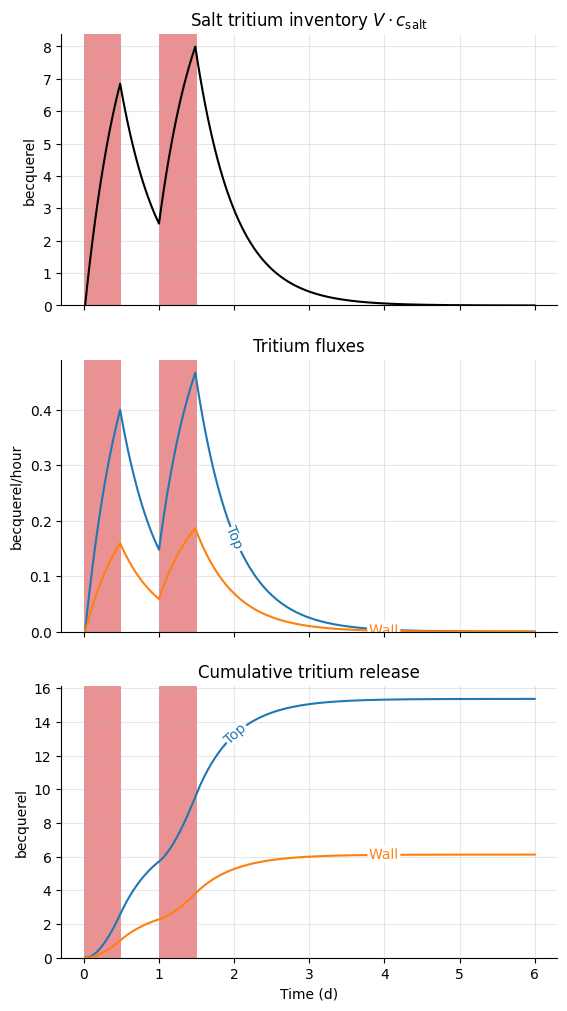

In [3]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="Top")
plt.plot(time, release_walls, label="Wall")

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = quantity_to_activity(baby_model.integrated_release_top()).to(ureg.Bq)
integrated_wall = quantity_to_activity(baby_model.integrated_release_wall()).to(ureg.Bq)

plt.plot(time, integrated_top, label="Top")
plt.plot(time, integrated_wall, label="Wall")
plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(alpha=0.3)
    labelLines(ax.get_lines(), zorder=2.5)
    for day in range(baby_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(
            0 * ureg.h + day * ureg.day,
            baby_model.exposure_time + day * ureg.day,
            facecolor="tab:red",
            alpha=0.5,
        )

plt.savefig("baby_run_3/basic_model_results.svg")
plt.show()


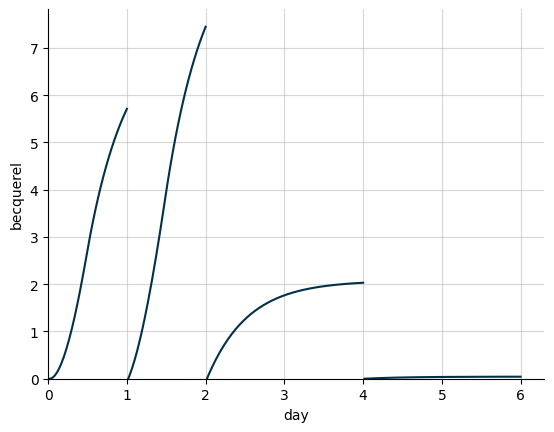

In [4]:
plt.figure()
plot_model(model=baby_model, walls=False, replacement_times=replacement_times)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/results_no_exp.svg")


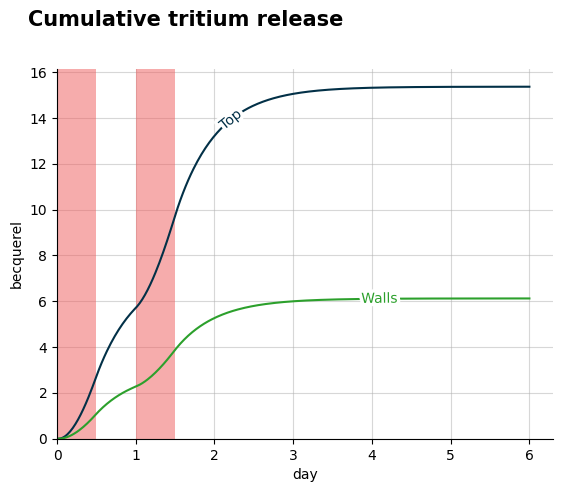

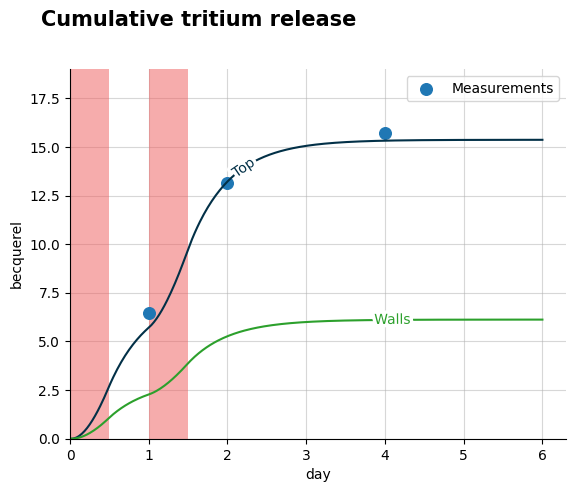

In [5]:
plot_model(
    model=baby_model,
    linelabel=True,
    irradiation=baby_model.irradiations,
)
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/cumulative_tritium_release_no_exp.svg")

plt.figure()
plot_model(
    model=baby_model,
    linelabel=True,
    irradiation=baby_model.irradiations,
)
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.ylim(top=19 * ureg.Bq)
plt.savefig("baby_run_3/cumulative_tritium_release.svg")


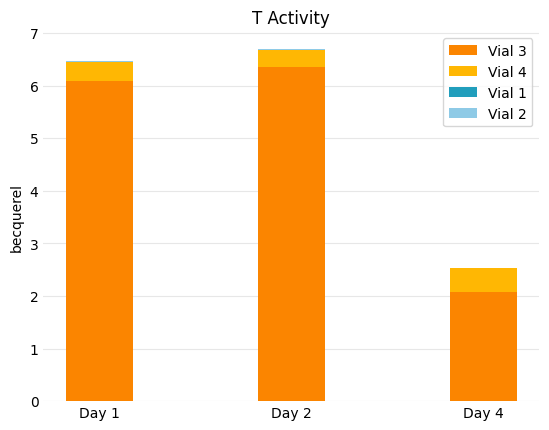

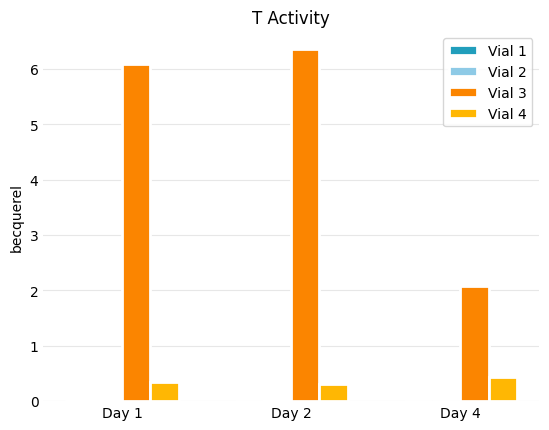

In [6]:
plt.figure()

for stacked in [True, False]:
    index = plot_bars(measurements_after_background_sub, stacked=stacked)
    plt.xticks(index, ["Day 1", "Day 2", "Day 4"])
    plt.title("T Activity")
    plt.legend()
    plt.gca().spines[["right", "bottom", "top", "left"]].set_visible(False)
    plt.grid(True, axis="y", alpha=0.3)
    plt.gca().tick_params(axis="both", which="both", length=0)
    if stacked:
        plt.savefig("baby_run_3/LSC results_stacked.svg")
    else:
        plt.savefig("baby_run_3/LSC results.svg")
    plt.gca().set_axisbelow(True)
    plt.show()


/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:448: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
/home/remidm/.local/lib/python3.10/site-packages/scipy/integrate/_quadrature.py:452: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)


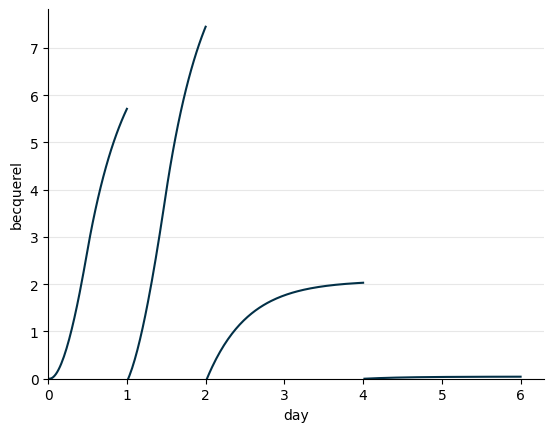

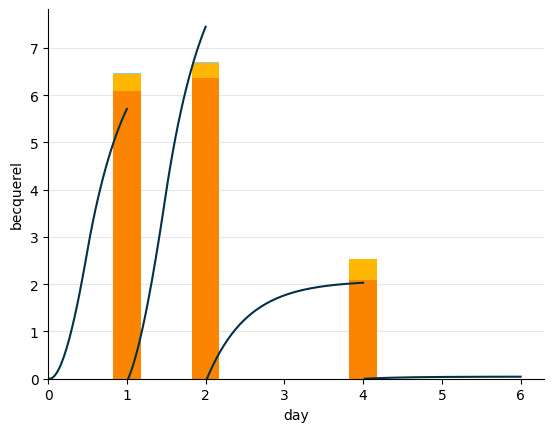

In [8]:
plt.figure()
plot_model(
    model=baby_model,
    walls=False,
    irradiation=False,
    linelabel=False,
    replacement_times=replacement_times,
)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/sample_activity_no_exp.svg")

plt.figure()
plot_bars(measurements_after_background_sub, index=[1 * ureg.day, 2 * ureg.day, 4 * ureg.day])
plot_model(
    model=baby_model,
    walls=False,
    irradiation=False,
    linelabel=False,
    replacement_times=replacement_times,
)
plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_3/sample_activity.svg")


In [9]:
m = measurements_after_background_sub
efficiency_1 = m[1][3] / (m[1][3] + m[1][4])
efficiency_2 = m[2][3] / (m[2][3] + m[2][4])

average_efficiency = np.mean([efficiency_1, efficiency_2])

nb_vials = 2
total_eff = 1 - (1 - average_efficiency) ** nb_vials
print(f"Average efficiency per vial {average_efficiency:.2%}")
print(f"Total efficiency ({nb_vials} vials): {total_eff:.2%}")


Average efficiency per vial 94.90%
Total efficiency (2 vials): 99.74%


/home/remidm/.local/lib/python3.10/site-packages/numpy/core/_methods.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  arr = asanyarray(a)


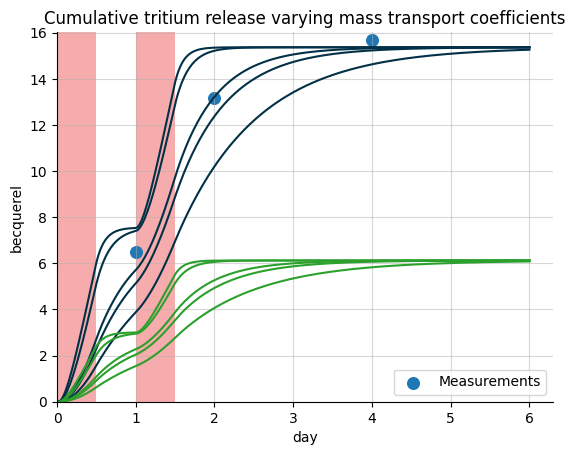

In [11]:
for i, mass_transport_coeff_factor2 in enumerate([0.5, 0.8, 1, 3, 5]):
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
    )

    new_baby_model.k_top *= mass_transport_coeff_factor * mass_transport_coeff_factor2
    new_baby_model.k_wall *= mass_transport_coeff_factor * mass_transport_coeff_factor2

    new_baby_model.number_days = baby_model.number_days
    new_baby_model.exposure_time = baby_model.exposure_time
    new_baby_model.irradiations = baby_model.irradiations
    new_baby_model.neutron_rate = baby_model.neutron_rate
    new_baby_model.dt = baby_model.dt
    new_baby_model.run(6 * ureg.day)
    if i == 0:
        irradiation = new_baby_model.irradiations
    else:
        irradiation = False
    plot_model(
        new_baby_model,
        linelabel=False,
        irradiation=irradiation,
    )
plt.title("Cumulative tritium release varying mass transport coefficients")
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])


## Potential experimental plan for next run

In [12]:
new_baby_model = Model(
    radius=baby_radius,
    height=baby_height,
    TBR=baby_model.TBR,
)

new_baby_model.k_top = baby_model.k_top
new_baby_model.k_wall = baby_model.k_wall

exposure_time = 3 * ureg.hour
resting_time = 0.5 * ureg.hour
cycle_time = exposure_time + resting_time
irradiations = []
for day in range(2):
    irradiations.append([day * ureg.day, day * ureg.day + exposure_time])
    while irradiations[-1][-1] + cycle_time < day * ureg.day + 12 * ureg.hour:
        irradiation_start = irradiations[-1][-1] + resting_time
        irradiation_stop = irradiation_start + exposure_time
        irradiations.append([irradiation_start, irradiation_stop])
new_baby_model.irradiations = irradiations
new_baby_model.neutron_rate = baby_model.neutron_rate
new_baby_model.dt = baby_model.dt
new_baby_model.run(6 * ureg.day)


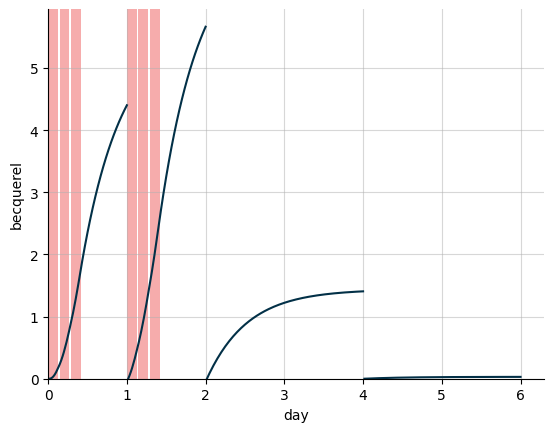

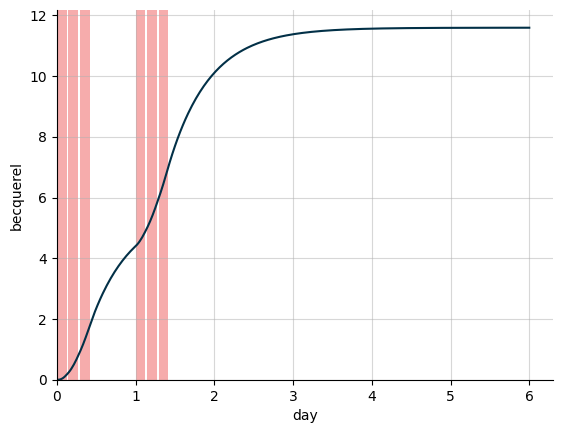

In [13]:
plot_model(
    new_baby_model,
    irradiation=new_baby_model.irradiations,
    replacement_times=replacement_times,
    walls=False,
)
plt.figure()
plot_model(
    new_baby_model,
    irradiation=new_baby_model.irradiations,
    walls=False,
)
